In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import pickle 
import os
from torch.autograd import Variable 
from torchvision import transforms 
from build_vocab import Vocab
from model import EncoderCNN, DecoderRNN
from PIL import Image

# Demo overview
The inference processes are encapsulated in the imageCaption() function. These processes includes
#### 1. Load image and trained model
#### 2. Test the sampler
#### 3. Gernerate and clean up sentence
#### 4. Show image and its corresponding caption

### 1. Load image and trained model

In [3]:
def preLoader(image_path, encoder_path, decoder_path, vocabulary_path, crop_size, embed_size, hidden_size, num_layers):
    """
    :param image_path: image path for input image
    :param encoder_path: trained encoder path
    :param decoder_path: trained decoder path
    :param vocabulary_path: vacabulary wrapper path
    :param crop_size: size for center cropping images
    :param embed_size: dimension of word embedding vectors
    :param hidden_size: dimension of lstm hidden states
    :param num_layers: number of layers in lstm
    :return: pretLoaded data including image, encoder, decoder, vacabulary and init_state of lstm.
    """
    
    ## load vocabulary wrapper
    with open(vocabulary_path, 'rb') as f:
        vocab = pickle.load(f)
        
    ## image transform parameter
    transform = transforms.Compose([ 
        transforms.Resize(crop_size),  
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    ## Load Image       
    image = Image.open(image_path)
    image_tensor = Variable(transform(image).unsqueeze(0)) ## increase dimension from 2 to 3
        
    ## Establish model
    encoder = EncoderCNN(embed_size)
    encoder.eval()  # encoder evaluation mode
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    decoder.eval()  # decoder evaluation mode
    
    # Load trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))
    
    # LSTM initial states
    init_state = (Variable(torch.zeros(num_layers, 1, hidden_size)),
             Variable(torch.zeros(num_layers, 1, hidden_size)))
    
    # Use gpu if available
    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()
        init_state = [s.cuda() for s in init_state]
        image_tensor = image_tensor.cuda()
        
    return image, image_tensor, encoder, decoder, init_state, vocab

### 2. Test sampler

In [4]:
def captionGenerator(image_tensor, encoder, decoder, init_state):
    """
    :param image_tensor: image tensor for the input image
    :param encoder: CNN layer instance
    :param decoder: RNN layer instance (LSTM)
    :param init_state: LSTM initial state
    :return: sample_id of lstm
    """
    # Generate caption from image
    feature = encoder(image_tensor)
    sampled_index = decoder.sample(feature, init_state)
    sampled_index = sampled_index.cpu().data.numpy()
    
    return sampled_index

### 3.  Generate  and clean up sentence

In [5]:
def wordsDecoder(sampled_idxs, vocab):
    """
    :param sampled_ids: the index of the words in vacabulary wrapper
    :param vocab: the loaded vacabulary wrapper
    :return: index the words in vacabulary, make up a whole sentence and clean the sentence up.
    """
    sampled_caption = []
    for word_id in sampled_idxs:
        word = vocab.idx_word_dict[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    sentence = sentence[8: -6] ## remove <start> <end>
    return sentence

In [6]:
def imageCaption(image, encoder_path='./data/encoder-5-3000.pkl', decoder_path='./data/decoder-5-3000.pkl',vocabulary_path='./data/vocab.pkl', crop_size=224, embed_size=256, hidden_size=512, num_layers=1):
    """
    :param image: the image for generating captions
    :param encoder_path: trained encoder path
    :param decoder_path: trained decoder path
    :param vocabulary_path: vacabulary wrapper path
    :param crop_size: size for center cropping images
    :param embed_size: dimension of word embedding vectors
    :param hidden_size: dimension of lstm hidden states
    :param num_layers: number of layers in lstm
    :return: the original image and its corresponding image caption
    """
    image, image_tensor, encoder, decoder, init_state, vocab = preLoader(image,encoder_path, decoder_path, vocabulary_path, crop_size, embed_size, hidden_size, num_layers)
    
    sampled_idxs = captionGenerator(image_tensor, encoder, decoder, init_state)
    
    # Decode word_ids to words
    sentence = wordsDecoder(sampled_idxs, vocab)
    
    # Print out image and generated caption.
    plt.imshow(np.asarray(image))
    print (sentence)

In [7]:
imageCaption(image="./test/test1.jpg")

AttributeError: Can't get attribute 'Vocabulary' on <module '__main__'>

a man riding a scooter down a street .


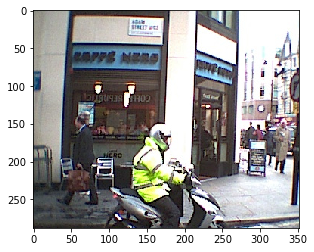

In [7]:
imageCaption(image="./test/test2.jpg")

a white plate with a piece of cake on it .


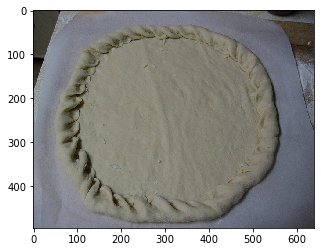

In [8]:
imageCaption(image="./test/test3.jpg")